In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
from glob import glob
import requests

In [14]:
files = glob("../Data/*.csv")
files

['../Data\\Adani Enterprises Limited.csv',
 '../Data\\Adani Green Energy Limited.csv',
 '../Data\\Adani Ports and Special Economic Zone Limited.csv',
 '../Data\\Adani Power Limited.csv',
 '../Data\\Adani Transmission Limited.csv',
 '../Data\\Infosys Limited.csv',
 '../Data\\ITC Limited.csv',
 '../Data\\Larsen & Toubro Limited.csv',
 '../Data\\Reliance Industries Limited.csv',
 '../Data\\Tata Consultancy Services Limited.csv']

In [15]:
df = pd.DataFrame()

for i in files:
    temp = pd.read_csv(i)
    df = df.append(temp)
df.shape

(32998, 8)

In [16]:
df = df.rename(columns = {"date": "Date", 
                          "open": "Open", 
                          "symbol": "Symbol"})

In [17]:
df["Date"] = pd.to_datetime(df["Date"])
df["Date"][120:].shape

(32878,)

In [18]:
df2 = df.copy()

In [19]:
df.columns

Index(['Date', 'Open', 'high', 'low', 'close', 'volume', 'Symbol', 'name'], dtype='object')

In [20]:
companies = df["symbol"].unique()
companies

KeyError: 'symbol'

In [27]:
# df = df[df["Symbol"] == companies[0]]
df = df[df["Symbol"] == 'RELIANCE.BSE']

In [28]:
c = 'RELIANCE.BSE'

In [29]:
df = df.sort_values(by = ["Date"], ascending=True)

In [30]:
training_set = df.loc[df["Symbol"] == c, "Open"].values
print(f"training on: {c}")
print(f"training data points: {len(training_set)}")
training_set = training_set.reshape(-1,1)
training_set[:5]

training on: RELIANCE.BSE
training data points: 4078


array([[388.7685],
       [399.9444],
       [392.8427],
       [392.469 ],
       [394.7115]])

In [31]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
sc = MinMaxScaler (feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled

array([[0.0039637 ],
       [0.00790099],
       [0.00539905],
       ...,
       [0.60589881],
       [0.61077814],
       [0.61916291]])

In [33]:
x_train = []
y_train = []
# 60 timesteps and 1 output
for i in range(60, len(training_set_scaled)):
    x_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = x_train[..., np.newaxis]
y_train = y_train[..., np.newaxis]

print(x_train.shape)
print(y_train.shape)

(4018, 60, 1)
(4018, 1)


## Modeling
> training on 60 days timestep

In [34]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [35]:
regressor = Sequential()

In [36]:
# Adding the first LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences=True, 
                   input_shape = (x_train.shape[1], 1)))
regressor.add(Dropout(0.2))

In [37]:
# Adding a second LSTM layer and some dropout regularisation
regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

In [38]:
# Adding a third LSTM Layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

In [32]:
# Adding the output Layer
regressor.add(Dense(units=1))

In [33]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 5

In [34]:
regressor.compile(optimizer="adam", loss="mean_squared_error")

In [35]:
regressor.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
126/126 [==============================] - 13s 103ms/step - loss: 0.0063
Epoch 2/10
126/126 [==============================] - 13s 105ms/step - loss: 0.0024
Epoch 3/10
126/126 [==============================] - 14s 111ms/step - loss: 0.0022
Epoch 4/10
126/126 [==============================] - 14s 112ms/step - loss: 0.0018
Epoch 5/10
126/126 [==============================] - 14s 110ms/step - loss: 0.0018
Epoch 6/10
126/126 [==============================] - 13s 104ms/step - loss: 0.0016
Epoch 7/10
126/126 [==============================] - 14s 108ms/step - loss: 0.0015
Epoch 8/10
126/126 [==============================] - 14s 108ms/step - loss: 0.0013
Epoch 9/10
126/126 [==============================] - 14s 111ms/step - loss: 0.0013
Epoch 10/10
126/126 [==============================] - 14s 111ms/step - loss: 0.0013


## Prediction test on same company data

In [39]:
dataset_total = df[df["Symbol"] == c]["Open"]
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []

for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(4018, 60, 1)

In [40]:
y_pred = regressor.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_pred.shape

(4018, 50)

ValueError: x and y must have same first dimension, but have shapes (4018,) and (200900,)

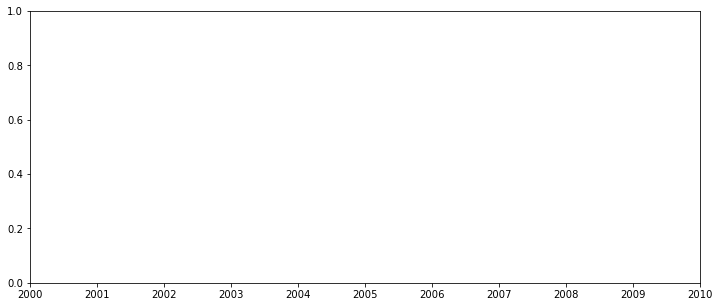

In [41]:
plt.figure(figsize=(12, 5))
plt.plot(df[df["Symbol"] == c]["Date"][60:], y_pred.flatten(), label="Predictions")
plt.plot(df[df["Symbol"] == c]["Date"], df[df["Symbol"] == c]["Open"], label="Actual", alpha=0.4)
plt.legend(loc=(1.01, 0.85))
plt.show()

In [40]:
check = pd.DataFrame(np.column_stack([df[df["Symbol"] == c]["Date"].values[60:].astype(str), 
                              df[df["Symbol"] == c]["Open"].values[60:], y_pred]),
             columns = ["Date", "True", "Predicted"]
            )
check["Date"] = pd.to_datetime(check["Date"])
check[["True", "Predicted"]] = check[["True", "Predicted"]].astype(float)

In [43]:
check["Date"].max()

Timestamp('2021-07-23 00:00:00')

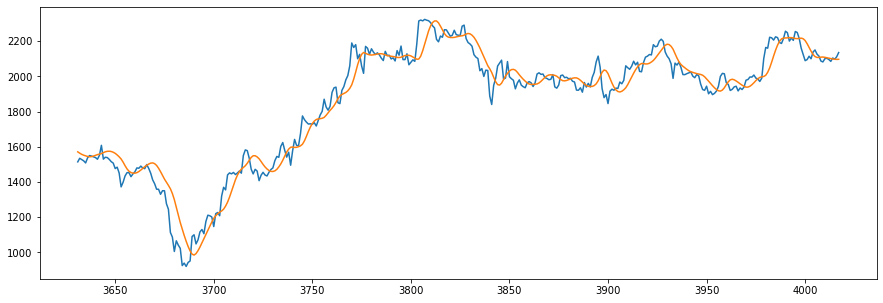

In [44]:
plt.figure(figsize=(15, 5))
plt.plot(check[check["Date"] > ("2020-01-01")]["True"])
plt.plot(check[check["Date"] > ("2020-01-01")]["Predicted"])


In [45]:
check = check.sort_values(by=["Date"], ascending=True)

In [46]:
# Rolling Match
rolling = 60
check["Previous"] = check["True"].shift(1)
check["Rolling_mean_predicted"] = check.rolling(rolling)["Predicted"].mean()
check["Rolling_mean_true"] = check.rolling(rolling)["True"].mean()
# check["Rolling_5_max"] = check.rolling(5)["Predicted"].max()

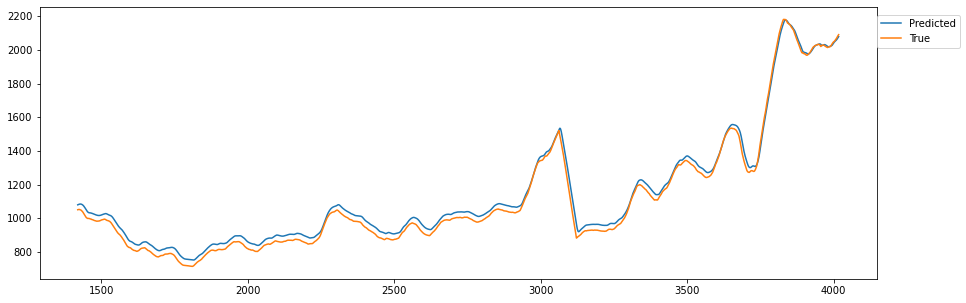

In [47]:
plt.figure(figsize=(15, 5))
plt.plot(check[check["Date"] > ("2011-01-01")]["Rolling_mean_predicted"], label="Predicted")
plt.plot(check[check["Date"] > ("2011-01-01")]["Rolling_mean_true"], label="True")
plt.legend(loc=(1, 0.85))
plt.show()

In [48]:
check["Trend_True"] = ""
check.loc[check["Rolling_mean_true"] > check["Previous"], "Trend_True"] = "Increasing"
check.loc[check["Rolling_mean_true"] == check["Previous"], "Trend_True"] = "Stable"
check.loc[check["Rolling_mean_true"] < check["Previous"], "Trend_True"] = "Decreasing"


check["Trend_Predicted"] = ""
check.loc[check["Rolling_mean_predicted"] > check["Previous"], "Trend_Predicted"] = "Increasing"
check.loc[check["Rolling_mean_predicted"] == check["Previous"], "Trend_Predicted"] = "Stable"
check.loc[check["Rolling_mean_predicted"] < check["Previous"], "Trend_Predicted"] = "Decreasing"

# check.head()

In [49]:
check["Trend_Match"] = ""
check.loc[check["Trend_True"] == check["Trend_Predicted"], "Trend_Match"] = 1
check.loc[check["Trend_True"] != check["Trend_Predicted"], "Trend_Match"] = 0

print(f"Percentage Match: { round(check['Trend_Match'].sum() * 100 / len(check), 2)}")

Percentage Match: 84.47


### Another Company

In [57]:
c = 'INFY.BSE'

In [70]:
dataset_total = df2[df2["Symbol"] == c]["Open"]
inputs = dataset_total.values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
x_test = []

for i in range(60, len(inputs)):
    x_test.append(inputs[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(4018, 60, 1)

In [71]:
y_pred = regressor.predict(x_test)
y_pred = sc.inverse_transform(y_pred)
y_pred.shape

(4018, 1)

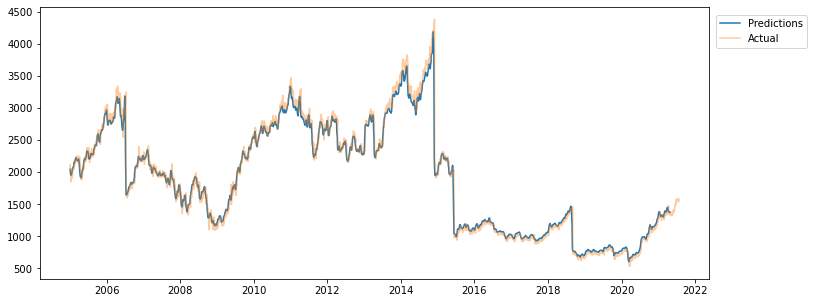

In [72]:
plt.figure(figsize=(12, 5))
plt.plot(df2[df2["Symbol"] == c]["Date"][60:], y_pred.flatten(), label="Predictions")
plt.plot(df2[df2["Symbol"] == c]["Date"], df2[df2["Symbol"] == c]["Open"], label="Actual", alpha=0.4)
plt.legend(loc=(1.01, 0.85))
plt.show()

In [73]:
c

'INFY.BSE'

In [74]:
check = pd.DataFrame(np.column_stack([df2[df2["Symbol"] == c]["Date"].values[60:].astype(str), 
                              df2[df2["Symbol"] == c]["Open"].values[60:], y_pred]),
             columns = ["Date", "True", "Predicted"]
            )
check["Date"] = pd.to_datetime(check["Date"])
check[["True", "Predicted"]] = check[["True", "Predicted"]].astype(float)

In [75]:
check["Date"].max()

Timestamp('2021-04-28 00:00:00')

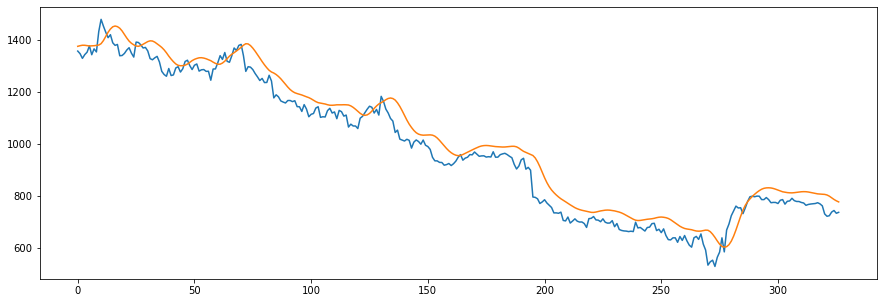

In [76]:
plt.figure(figsize=(15, 5))
plt.plot(check[check["Date"] > ("2020-01-01")]["True"])
plt.plot(check[check["Date"] > ("2020-01-01")]["Predicted"])


In [77]:
check = check.sort_values(by=["Date"], ascending=True)

In [88]:
# Rolling Match
rolling = 30
check["Previous"] = check["True"].shift(1)
check["Rolling_mean_predicted"] = check.rolling(rolling)["Predicted"].mean()
check["Rolling_mean_true"] = check.rolling(rolling)["True"].mean()
# check["Rolling_5_max"] = check.rolling(5)["Predicted"].max()

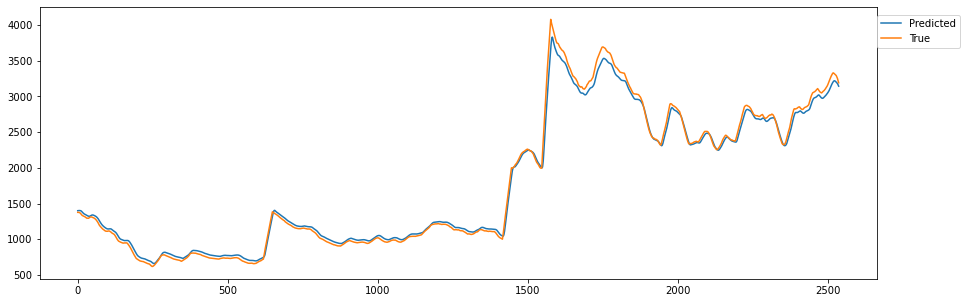

In [89]:
plt.figure(figsize=(15, 5))
plt.plot(check[check["Date"] > ("2011-01-01")]["Rolling_mean_predicted"], label="Predicted")
plt.plot(check[check["Date"] > ("2011-01-01")]["Rolling_mean_true"], label="True")
plt.legend(loc=(1, 0.85))
plt.show()

In [90]:
check["Trend_True"] = ""
check.loc[check["Rolling_mean_true"] > check["Previous"], "Trend_True"] = "Increasing"
check.loc[check["Rolling_mean_true"] == check["Previous"], "Trend_True"] = "Stable"
check.loc[check["Rolling_mean_true"] < check["Previous"], "Trend_True"] = "Decreasing"


check["Trend_Predicted"] = ""
check.loc[check["Rolling_mean_predicted"] > check["Previous"], "Trend_Predicted"] = "Increasing"
check.loc[check["Rolling_mean_predicted"] == check["Previous"], "Trend_Predicted"] = "Stable"
check.loc[check["Rolling_mean_predicted"] < check["Previous"], "Trend_Predicted"] = "Decreasing"

# check.head()

In [91]:
check["Trend_Match"] = ""
check.loc[check["Trend_True"] == check["Trend_Predicted"], "Trend_Match"] = 1
check.loc[check["Trend_True"] != check["Trend_Predicted"], "Trend_Match"] = 0

print(f"Percentage Match: { round(check['Trend_Match'].sum() * 100 / len(check), 2)}")

Percentage Match: 76.26


In [4]:
import tensorflow as tf

In [6]:
model = tf.keras.models.load_model("../Models/OpenPricePrediction.h5")

In [43]:
pred_y = model.predict(x_test)

In [46]:
df2[df2["Symbol"] == c]["Open"].shape

(4078,)

In [49]:
y_pred = sc.inverse_transform(pred_y)

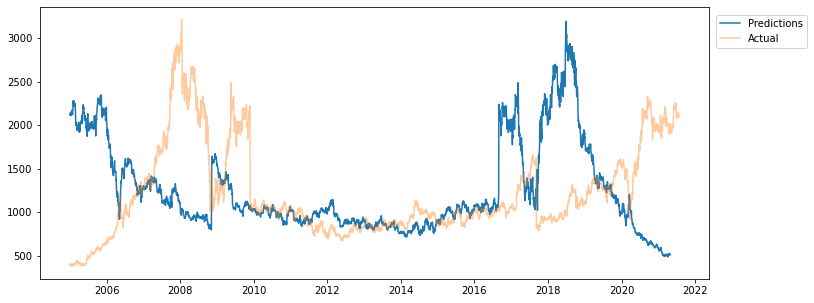

In [50]:
plt.figure(figsize=(12, 5))
plt.plot(df2[df2["Symbol"] == c]["Date"][60:], y_pred.flatten(), label="Predictions")
plt.plot(df2[df2["Symbol"] == c]["Date"], df2[df2["Symbol"] == c]["Open"], label="Actual", alpha=0.4)
plt.legend(loc=(1.01, 0.85))
plt.show()